In [1]:
import nilearn
import nistats

In [2]:
subj_idx = '001'

In [3]:
import os

In [4]:
path = os.path.join(os.environ['HOME'], 'data/openfmri/ds164/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-stroop'.format(**locals()))

In [5]:
data = [path + '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',]

mask = path + '_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'

confounds = [path+ '_bold_confounds.tsv']

In [6]:
# TR is 1.5 seconds
t_r = 1.5

In [7]:
from nistats.first_level_model import FirstLevelModel
first_level_model = FirstLevelModel(t_r, hrf_model='glover + derivative', smoothing_fwhm=8.0, mask=mask)

In [8]:
import pandas
import numpy as np

def get_onsets(subj_idx):
    
    path = os.environ['HOME'] + '/data/openfmri/ds164/'
    fn = path + 'sub-{subj_idx}/func/sub-{subj_idx}_task-stroop_events.tsv'.format(**locals())
    df = pandas.read_csv(fn, sep='\t', na_values=['n/a'])
        
    df = df[~df.duration.isnull()]
    
    df['trial_type'] = df.condition

    return df
    

In [9]:
paradigm = [get_onsets(subj_idx)]

In [10]:
first_level_model.fit(data, paradigm, confounds=confounds)

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask='/home/ubuntu/data/openfmri/ds164/derivatives/fmriprep/sub-001/func/sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=1, noise_model='ar1', period_cut=128,
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=8.0,
        standardize=False, subject_label=None, t_r=1.5, target_affine=None,
        target_shape=None, verbose=0)

In [11]:
zmap = first_level_model.compute_contrast('incongruent - congruent')

In [12]:
import nilearn
from nilearn import plotting
%matplotlib inline

/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


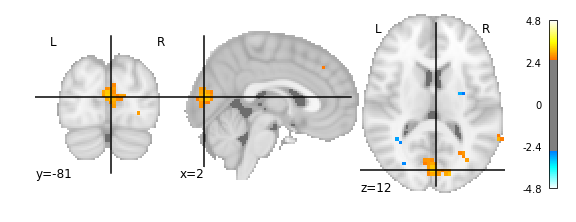

In [13]:
nilearn.plotting.plot_stat_map(zmap, threshold=2.6)

Subject 001
Subject 002
Subject 003
Subject 004
Subject 005
Subject 006
Subject 007
Subject 008
Subject 009
Subject 010
Subject 011
Subject 012
Subject 013
Subject 014
Subject 015
Subject 016
Subject 017
Subject 018
Subject 019
Subject 020
Subject 021


/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Subject 022
Subject 023
Subject 024
Subject 025
Subject 026
Subject 027
Subject 028


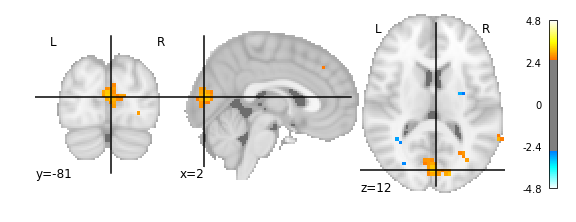

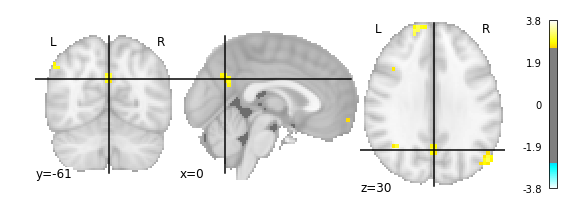

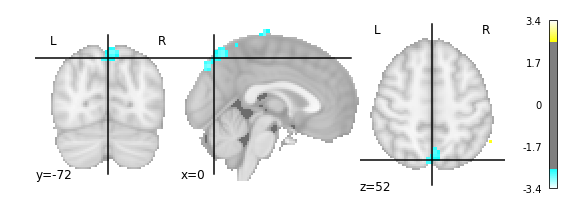

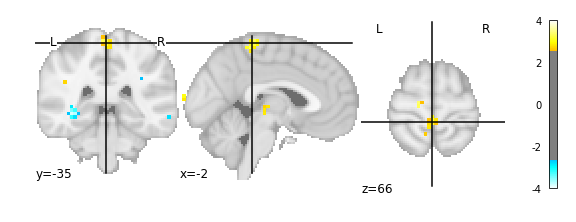

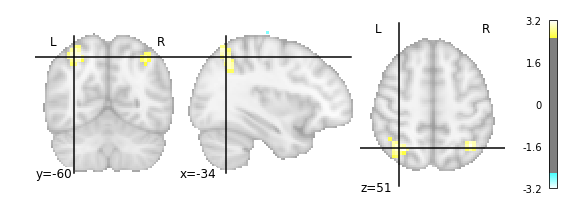

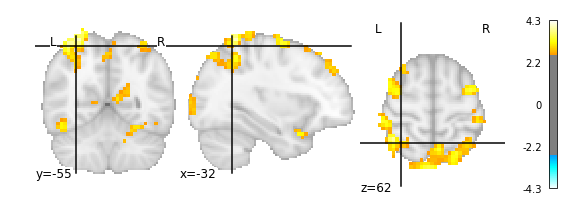

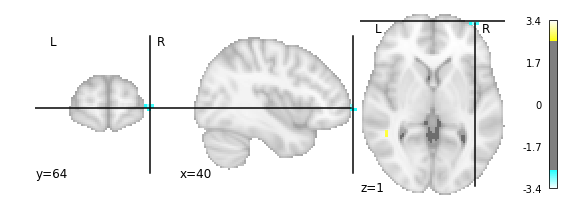

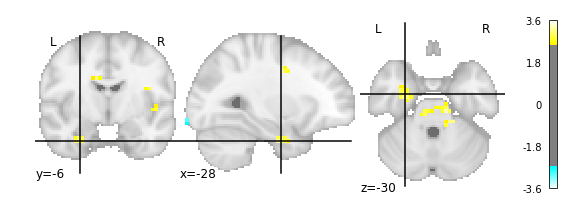

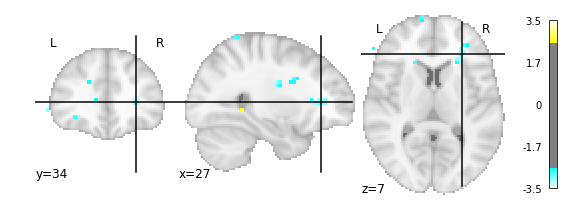

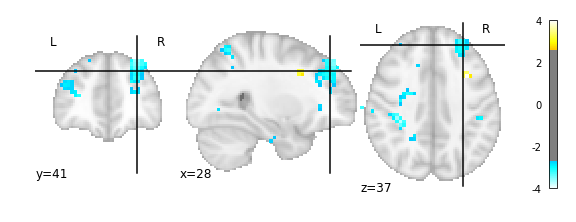

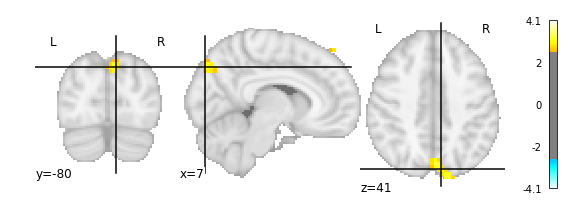

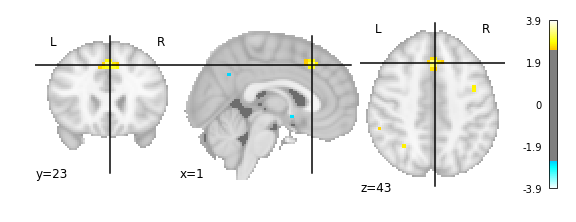

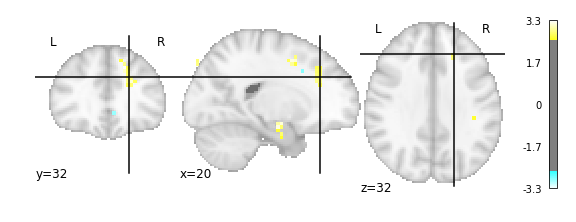

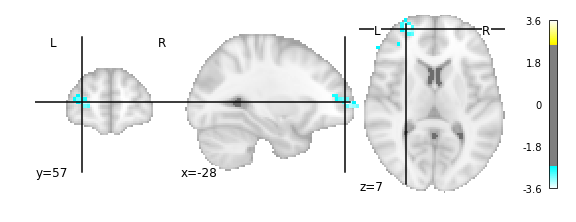

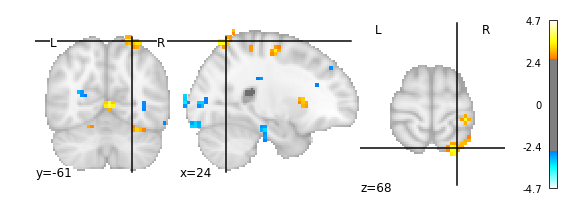

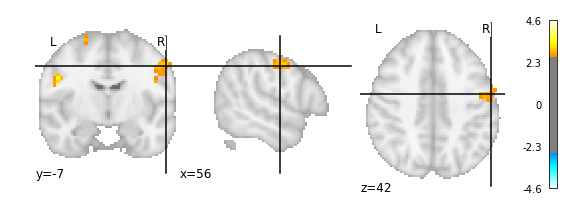

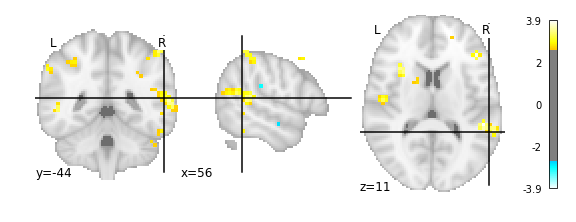

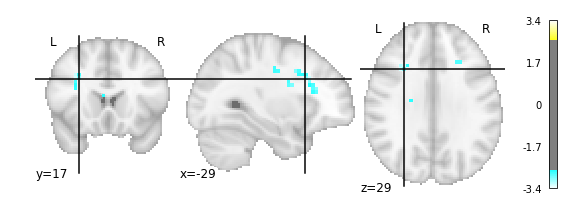

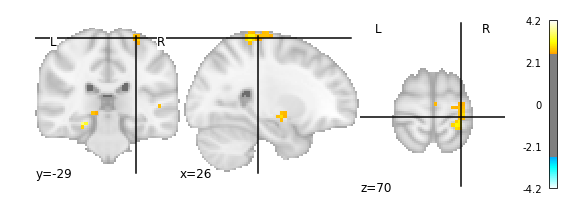

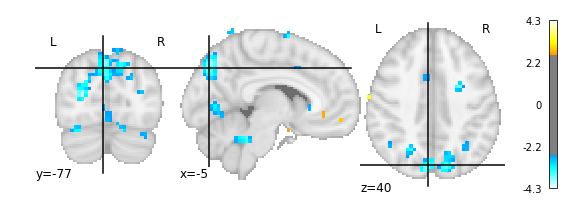

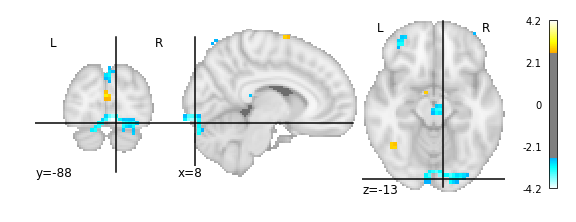

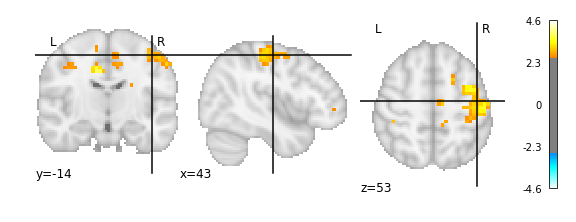

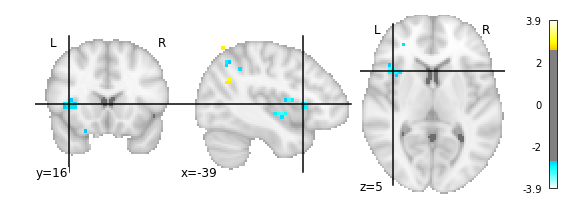

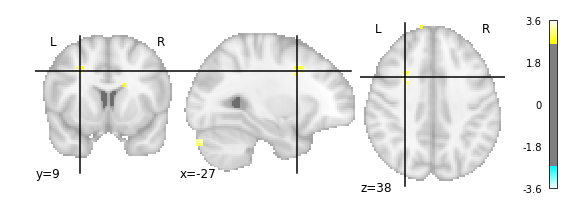

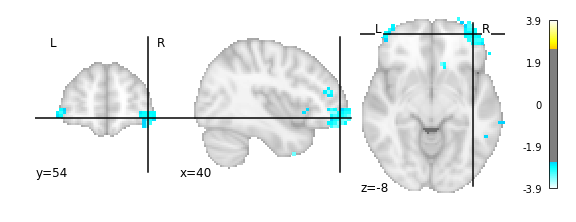

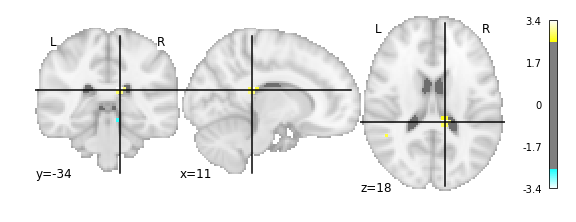

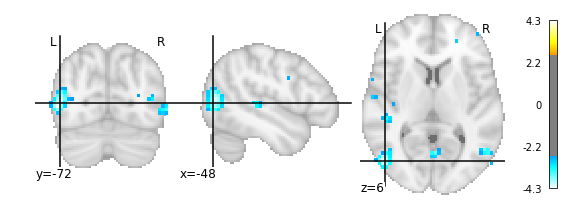

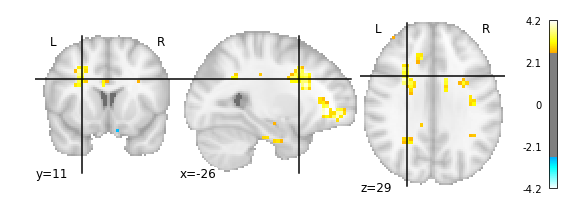

In [14]:
# Make an empty list to put fitted first level models in
models = []
subjects = ['%03d' % i for i in range(1, 29)]

for subj_idx in subjects[:]:

    print("Subject %s" % subj_idx)

    # set up path
    path = os.path.join(os.environ['HOME'], 'data/openfmri/ds164/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-stroop'.format(**locals()))

    data = [path + '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',]

    mask = path + '_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'

    confounds = [path+ '_bold_confounds.tsv']

    
    # Set up model, we have to give:
    # * the TR (time it takes to acquire one functional volume)
    # * The HRF-model (we use a standard double-gamma model + derivative)
    # * The amount of smoothing (we use ample, 8.0 mm)
    # * The mask (Saves time, we do not estimate models outside of the brain)
    first_level_model = FirstLevelModel(t_r, hrf_model='glover + derivative', smoothing_fwhm=8.0, mask=mask)
    
    # Fit model, including all confounds (motion parameters, tcompcorr, etc.)
#     first_level_model.fit(data, paradigm, confounds=confounds,)
    first_level_model.fit(data, paradigm)
    
    # Compute contrast incongruent > congruent
    zmap = first_level_model.compute_contrast('incongruent - congruent')
    
    # Plot resulting zmap, with (arbitrary but stringent) threshold at 2.6
    nilearn.plotting.plot_stat_map(zmap, threshold=2.6)

    
    # make list of models and subjects that we processed
    models.append(first_level_model)

In [15]:
contrasts = [model.compute_contrast('incongruent - congruent') for model in models]

In [16]:
design_matrix = pandas.DataFrame({'intercept':np.ones(len(contrasts))},)

In [17]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=0.0)
second_level_model = second_level_model.fit(contrasts, design_matrix=design_matrix)
z_map = second_level_model.compute_contrast('intercept')

In [18]:
from IPython.display import FileLink

/home/ubuntu/summerschool2017_notebooks/ds164/inc_congruent.nii.gz

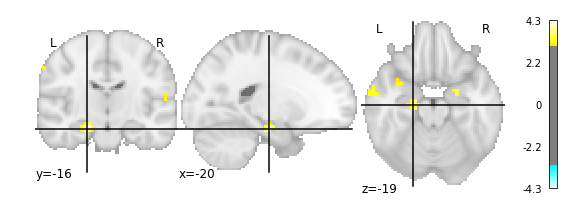

In [19]:
plotting.plot_stat_map(z_map, threshold=3.1 )

z_map.to_filename('inc_congruent.nii.gz')
FileLink('inc_congruent.nii.gz')

## Model-based

In [30]:
drifts = pandas.read_csv('stroop_v.csv')

In [31]:
drifts = drifts.pivot_table(index='subj_idx', columns='tag', values='mean')
design_matrix = pandas.DataFrame({'intercept':np.ones(len(contrasts))}, index=np.arange(1, 29))
design_matrix['drift_difference'] = drifts['congruent'] - drifts['incongruent']
design_matrix['drift_difference'] -= design_matrix['drift_difference'].mean()

In [32]:
design_matrix

,intercept,drift_difference
1,1.0,0.200756
2,1.0,-0.319124
3,1.0,-0.374944
4,1.0,0.238422
5,1.0,-0.046313
6,1.0,-0.552595
7,1.0,0.775374
8,1.0,-0.503622
9,1.0,-0.013543
10,1.0,0.046631


In [33]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=0.0)
second_level_model = second_level_model.fit(contrasts, design_matrix=design_matrix)
z_map = second_level_model.compute_contrast('drift_difference')

/home/ubuntu/summerschool2017_notebooks/ds164/drift_difference.nii.gz

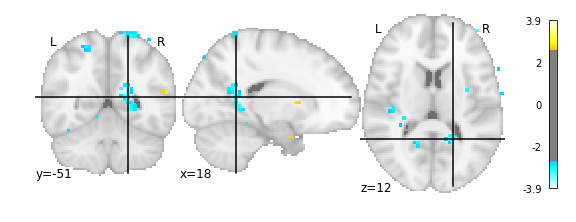

In [37]:
plotting.plot_stat_map(z_map, threshold=2.6)

z_map.to_filename('drift_difference.nii.gz')
FileLink('drift_difference.nii.gz')

In [26]:
startpoints = pandas.read_csv('stroop_z.csv')

In [27]:
startpoints = startpoints.pivot_table(index='subj_idx', columns='tag', values='mean')
design_matrix = pandas.DataFrame({'intercept':np.ones(len(contrasts))}, index=np.arange(1, 29))
design_matrix['start_point_diff'] = startpoints['congruent'] - startpoints['incongruent']
design_matrix['start_point_diff'] -= design_matrix['start_point_diff'].mean()

In [28]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=0.0)
second_level_model = second_level_model.fit(contrasts, design_matrix=design_matrix)
z_map = second_level_model.compute_contrast('start_point_diff')

/home/ubuntu/summerschool2017_notebooks/ds164/start_point_diff.nii.gz

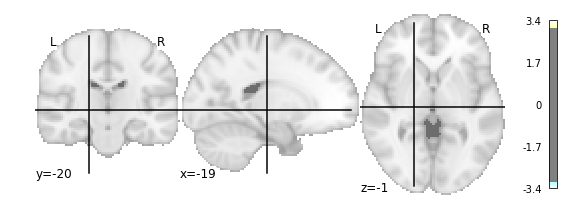

In [29]:
plotting.plot_stat_map(z_map, threshold=3.1 )

z_map.to_filename('start_point_diff.nii.gz')
FileLink('start_point_diff.nii.gz')